# Constituent-based Syntactic Parsing with NLTK
### http://www.cs.bgu.ac.il/~elhadad/nlp20.html

NLTK contains classes to work with PCFGs. This document reviews existing building blocks in NLTK 3.4.

1. Treebank
1. Trees
1. CFG
1. PCFG
1. Parsers

## Treebank

NLTK includes a 5% fragment of the Penn Treebank corpus (about 4,000 sentences). You can observe the parsed trees using the treebank corpus reader:

In [1]:
import nltk
print(nltk.corpus.treebank.parsed_sents('wsj_0001.mrg')[0])

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


The draw() method produces a graphical rendering of the trees (in a separate window):

In [2]:
# nltk.corpus.treebank.parsed_sents('wsj_0001.mrg')[0].draw()

To get a tree displayed in a Jupyter notebook, use the following method:

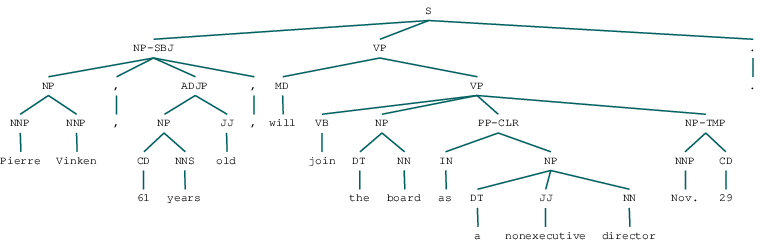

In [3]:
import IPython
IPython.core.display.display(nltk.corpus.treebank.parsed_sents('wsj_0001.mrg')[0])

## Trees

NLTK includes a [tree](http://www.nltk.org/_modules/nltk/tree.html) class. 

The class has accessors for root and children, parsers to read a parenthesized representation of trees, mutators to change nodes within a tree, and tree transformations to turn a tree into a Chomsky-Normal-Form (CNF) tree. There is also a method to draw trees in a graphical manner. The code in nltk.tree.demo() demonstrates how this class can be used.

In [4]:
from nltk import Tree

# Parse a tree from a string with parentheses.
s = '(S (NP (DT the) (NN cat)) (VP (VBD ate) (NP (DT a) (NN cookie))))'
t = Tree.fromstring(s)
print("Convert bracketed string into tree:")
print(t)
print(t.__repr__())

Convert bracketed string into tree:
(S (NP (DT the) (NN cat)) (VP (VBD ate) (NP (DT a) (NN cookie))))
Tree('S', [Tree('NP', [Tree('DT', ['the']), Tree('NN', ['cat'])]), Tree('VP', [Tree('VBD', ['ate']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['cookie'])])])])


### Tree Accessors

In [5]:
print("Display tree properties:")
print(t.label())   # tree's constituent type
print(t[0]) # tree's first child
print(t[1]) # tree's second child

Display tree properties:
S
(NP (DT the) (NN cat))
(VP (VBD ate) (NP (DT a) (NN cookie)))


In [6]:
print(t.height())

5


In [7]:
print(t.leaves())

['the', 'cat', 'ate', 'a', 'cookie']


In [8]:
print(t[1])
print(t[1,1])
print(t[1,1,0])

(VP (VBD ate) (NP (DT a) (NN cookie)))
(NP (DT a) (NN cookie))
(DT a)


### Tree Mutators

In [9]:
# Demonstrate tree modification.
the_cat = t[0]
the_cat.insert(1, Tree.fromstring('(JJ big)'))
print("Tree modification:")
print(t)
t[1,1,1] = Tree.fromstring('(NN cake)')
print(t)

Tree modification:
(S
  (NP (DT the) (JJ big) (NN cat))
  (VP (VBD ate) (NP (DT a) (NN cookie))))
(S
  (NP (DT the) (JJ big) (NN cat))
  (VP (VBD ate) (NP (DT a) (NN cake))))


### Tree Transformations

In [10]:
# Tree transforms
print("Collapse unary:")
t.collapse_unary()
print(t)
print("Chomsky normal form:")
t.chomsky_normal_form()
print(t)

Collapse unary:
(S
  (NP (DT the) (JJ big) (NN cat))
  (VP (VBD ate) (NP (DT a) (NN cake))))
Chomsky normal form:
(S
  (NP (DT the) (NP|<JJ-NN> (JJ big) (NN cat)))
  (VP (VBD ate) (NP (DT a) (NN cake))))


### Probabilistic Trees

In [11]:
# Demonstrate probabilistic trees.
pt = nltk.tree.ProbabilisticTree('x', ['y', 'z'], prob=0.5)
print("Probabilistic Tree:")
print(pt)

Probabilistic Tree:
(x y z) (p=0.5)


In [12]:
# Demonstrate LaTeX output
print("LaTeX output:")
print(t.pformat_latex_qtree())

LaTeX output:
\Tree [.S
        [.NP [.DT the ] [.NP|<JJ-NN> [.JJ big ] [.NN cat ] ] ]
        [.VP [.VBD ate ] [.NP [.DT a ] [.NN cake ] ] ] ]


In [13]:
print(t)

# Demonstrate Productions
print("Production output:")
print(t.productions())


(S
  (NP (DT the) (NP|<JJ-NN> (JJ big) (NN cat)))
  (VP (VBD ate) (NP (DT a) (NN cake))))
Production output:
[S -> NP VP, NP -> DT NP|<JJ-NN>, DT -> 'the', NP|<JJ-NN> -> JJ NN, JJ -> 'big', NN -> 'cat', VP -> VBD NP, VBD -> 'ate', NP -> DT NN, DT -> 'a', NN -> 'cake']


In [14]:
# Demonstrate tree nodes containing objects other than strings
t.set_label(('test', 3))
print(t)

(('test', 3)
  (NP (DT the) (NP|<JJ-NN> (JJ big) (NN cat)))
  (VP (VBD ate) (NP (DT a) (NN cake))))


## CFG

NLTK includes several classes to encode CFG and PCFG grammars in the nltk.grammar module:

1. Nonterminal
1. Production (for rules)
1. WeightedProduction (for rules in a PCFG)
1. ContextFreeGrammar
1. PCFG

The classes include convenient parsers to convert strings into grammars.
The method grammar.check_coverage(ws) determines whether the words that appear in ws can ever be parsed by the grammar.

The function nltk.grammar.cfg_demo() illustrates how these classes are used.


In [15]:
from nltk import nonterminals, Nonterminal, Production

# Create some nonterminals
S, NP, VP, PP = nonterminals('S, NP, VP, PP')
N, V, P, Det = nonterminals('N, V, P, Det')
VP_slash_NP = Nonterminal('VP/NP')

print('Some nonterminals:', [S, NP, VP, PP, N, V, P, Det, VP_slash_NP])
print('S.symbol() =>', S.symbol())

Some nonterminals: [S, NP, VP, PP, N, V, P, Det, VP/NP]
S.symbol() => S


In [16]:
print(Production(S, [NP]))

S -> NP


In [17]:
# Create some Grammar Productions
from nltk import CFG

grammar = CFG.fromstring("""
  S -> NP VP
  PP -> P NP
  NP -> Det N | NP PP
  VP -> V NP | VP PP
  Det -> 'a' | 'the'
  N -> 'dog' | 'cat'
  V -> 'chased' | 'sat'
  P -> 'on' | 'in'
""")

print('A Grammar:', grammar)
print('grammar.start()   =>', grammar.start())
print('grammar.productions() =>')
# Use string.replace(...) is to line-wrap the output.
print(grammar.productions())


A Grammar: Grammar with 14 productions (start state = S)
    S -> NP VP
    PP -> P NP
    NP -> Det N
    NP -> NP PP
    VP -> V NP
    VP -> VP PP
    Det -> 'a'
    Det -> 'the'
    N -> 'dog'
    N -> 'cat'
    V -> 'chased'
    V -> 'sat'
    P -> 'on'
    P -> 'in'
grammar.start()   => S
grammar.productions() =>
[S -> NP VP, PP -> P NP, NP -> Det N, NP -> NP PP, VP -> V NP, VP -> VP PP, Det -> 'a', Det -> 'the', N -> 'dog', N -> 'cat', V -> 'chased', V -> 'sat', P -> 'on', P -> 'in']


In [18]:
print('Coverage of input words by a grammar:')
try:
    grammar.check_coverage(['a','dog'])
    print("All words covered")
except:
    print("Strange")
try:
    print(grammar.check_coverage(['a','toy']))
except:
    print("Some words not covered")


Coverage of input words by a grammar:
All words covered
Some words not covered


## PCFG

PCFGs are very similar to CFGs - they just have an additional probability for each production.
For a given left-hand-side non-terminal, the sum of the probabilities must be 1.0.

In [19]:
from nltk import PCFG
toy_pcfg1 = PCFG.fromstring("""
    S -> NP VP [1.0]
    NP -> Det N [0.5] | NP PP [0.25] | 'John' [0.1] | 'I' [0.15]
    Det -> 'the' [0.8] | 'my' [0.2]
    N -> 'man' [0.5] | 'telescope' [0.5]
    VP -> VP PP [0.1] | V NP [0.7] | V [0.2]
    V -> 'ate' [0.35] | 'saw' [0.65]
    PP -> P NP [1.0]
    P -> 'with' [0.61] | 'under' [0.39]
""")

The function nltk.grammar.pcfg_demo() illustrates how PCFGs can be constructed and manipulated.
The most important method consists of inducing a PCFG from trees in a treebank (induce_pcfg()).
Before we induce the PCFG, we take care of transforming the trees into CNF.
Note how tree.productions() returns the list of CFG rules that "explain" the tree:
for each non-terminal node in the tree, tree.productions() will return a production with the
parent node as LHS and the children as RHS.


In [20]:
from nltk.corpus import treebank
from nltk import treetransforms
from nltk import induce_pcfg
from nltk.parse import pchart

pcfg_prods = toy_pcfg1.productions()

pcfg_prod = pcfg_prods[2]
print('A PCFG production:', pcfg_prod)
print('pcfg_prod.lhs()  =>', pcfg_prod.lhs())
print('pcfg_prod.rhs()  =>', pcfg_prod.rhs())
print('pcfg_prod.prob() =>', pcfg_prod.prob())

A PCFG production: NP -> NP PP [0.25]
pcfg_prod.lhs()  => NP
pcfg_prod.rhs()  => (NP, PP)
pcfg_prod.prob() => 0.25


In [21]:
# extract productions from three trees and induce the PCFG
print("Induce PCFG grammar from treebank data:")

productions = []
for item in treebank.fileids()[:2]:
  for tree in treebank.parsed_sents(item):
    # perform optional tree transformations, e.g.:
    tree.collapse_unary(collapsePOS = False)# Remove branches A-B-C into A-B+C
    tree.chomsky_normal_form(horzMarkov = 2)# Remove A->(B,C,D) into A->B,C+D->D
    productions += tree.productions()

Induce PCFG grammar from treebank data:


In [22]:
from nltk import Nonterminal
S = Nonterminal('S')
grammar = induce_pcfg(S, productions)
print(grammar)

Grammar with 86 productions (start state = S)
    S -> NP-SBJ S|<VP-.> [0.5]
    NP-SBJ -> NP NP-SBJ|<,-ADJP> [0.333333]
    NP -> NNP NNP [0.2]
    NNP -> 'Pierre' [0.0714286]
    NNP -> 'Vinken' [0.142857]
    NP-SBJ|<,-ADJP> -> , NP-SBJ|<ADJP-,> [1.0]
    , -> ',' [1.0]
    NP-SBJ|<ADJP-,> -> ADJP , [1.0]
    ADJP -> NP JJ [1.0]
    NP -> CD NNS [0.133333]
    CD -> '61' [0.333333]
    NNS -> 'years' [1.0]
    JJ -> 'old' [0.285714]
    S|<VP-.> -> VP . [1.0]
    VP -> MD VP [0.2]
    MD -> 'will' [1.0]
    VP -> VB VP|<NP-PP-CLR> [0.2]
    VB -> 'join' [1.0]
    VP|<NP-PP-CLR> -> NP VP|<PP-CLR-NP-TMP> [1.0]
    NP -> DT NN [0.0666667]
    DT -> 'the' [0.4]
    NN -> 'board' [0.142857]
    VP|<PP-CLR-NP-TMP> -> PP-CLR NP-TMP [1.0]
    PP-CLR -> IN NP [1.0]
    IN -> 'as' [0.25]
    NP -> DT NP|<JJ-NN> [0.133333]
    DT -> 'a' [0.4]
    NP|<JJ-NN> -> JJ NN [1.0]
    JJ -> 'nonexecutive' [0.285714]
    NN -> 'director' [0.285714]
    NP-TMP -> NNP CD [1.0]
    NNP -> 'Nov.' [0.0714286

## Parsers

There are different types of parsers implemented in NLTK. One that implements the Viterbi CKY n-best parses over a PCFG is available in 
the [parse.viterbi](http://www.nltk.org/_modules/nltk/parse/viterbi.html) module.

In [23]:
print("Parse sentence using induced grammar:")

parser = pchart.InsideChartParser(grammar)
parser.trace(3)

sent = treebank.parsed_sents('wsj_0001.mrg')[0].leaves()
print(sent)

for parse in parser.parse(sent):
  print(parse)

Parse sentence using induced grammar:
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
  |[-] . . . . . . . . . . . . . . . . .| [0:1] 'Pierre' [1.0]
  |. [-] . . . . . . . . . . . . . . . .| [1:2] 'Vinken' [1.0]
  |. . [-] . . . . . . . . . . . . . . .| [2:3] ','  [1.0]
  |. . . [-] . . . . . . . . . . . . . .| [3:4] '61' [1.0]
  |. . . . [-] . . . . . . . . . . . . .| [4:5] 'years' [1.0]
  |. . . . . [-] . . . . . . . . . . . .| [5:6] 'old' [1.0]
  |. . . . . . [-] . . . . . . . . . . .| [6:7] ','  [1.0]
  |. . . . . . . [-] . . . . . . . . . .| [7:8] 'will' [1.0]
  |. . . . . . . . [-] . . . . . . . . .| [8:9] 'join' [1.0]
  |. . . . . . . . . [-] . . . . . . . .| [9:10] 'the' [1.0]
  |. . . . . . . . . . [-] . . . . . . .| [10:11] 'board' [1.0]
  |. . . . . . . . . . . [-] . . . . . .| [11:12] 'as' [1.0]
  |. . . . . . . . . . . . [-] . . . . .| [12:13] 'a' [1.0]
  |. . . . . . . . . . . .

The parsers are defined in module nltk.parse.

In [24]:
import sys, time
from nltk import tokenize
from nltk.grammar import toy_pcfg1
from nltk.parse import pchart
from nltk.parse import ViterbiParser

demos = [('I saw John with my telescope', toy_pcfg1)]
sent, grammar = demos[0]

# Tokenize the sentence.
tokens = sent.split()

# Define a list of parsers.  We'll use all parsers.
parsers = [
ViterbiParser(grammar),
pchart.InsideChartParser(grammar),
pchart.RandomChartParser(grammar),
pchart.UnsortedChartParser(grammar),
pchart.LongestChartParser(grammar),
pchart.InsideChartParser(grammar, beam_size = len(tokens)+1)
]

In [25]:
# Run the parsers on the tokenized sentence.
from functools import reduce
times = []
average_p = []
num_parses = []
all_parses = {}
for parser in parsers:
    print('\ns: %s\nparser: %s\ngrammar: %s' % (sent,parser,grammar))
    parser.trace(3)
    t = time.time()
    parses = parser.parse_all(tokens)
    times.append(time.time()-t)
    if parses: 
        lp = len(parses)
        p = reduce(lambda a,b:a+b.prob(), parses, 0.0)
    else: 
        p = 0
    average_p.append(p)
    num_parses.append(len(parses))
    for p in parses: 
        all_parses[p.freeze()] = 1

# Print summary statistics
print()
print('-------------------------+------------------------------------------')
print('   Parser           Beam | Time (secs)   # Parses   Average P(parse)')
print('-------------------------+------------------------------------------')
for i in range(len(parsers)):
    print('%19s %4d |%11.4f%11d%19.14f' % (parsers[i].__class__.__name__,
      getattr(parsers[0], "beam_size", 0),
      times[i], 
      num_parses[i], 
      average_p[i]))
parses = all_parses.keys()
if parses: 
    p = reduce(lambda a,b:a+b.prob(), parses, 0)/len(parses)
else: 
    p = 0
print('-------------------------+------------------------------------------')
print('%19s      |%11s%11d%19.14f' % ('(All Parses)', 'n/a', len(parses), p))
print()

for parse in parses:
    print(parse)



s: I saw John with my telescope
parser: <ViterbiParser for <Grammar with 17 productions>>
grammar: Grammar with 17 productions (start state = S)
    S -> NP VP [1.0]
    NP -> Det N [0.5]
    NP -> NP PP [0.25]
    NP -> 'John' [0.1]
    NP -> 'I' [0.15]
    Det -> 'the' [0.8]
    Det -> 'my' [0.2]
    N -> 'man' [0.5]
    N -> 'telescope' [0.5]
    VP -> VP PP [0.1]
    VP -> V NP [0.7]
    VP -> V [0.2]
    V -> 'ate' [0.35]
    V -> 'saw' [0.65]
    PP -> P NP [1.0]
    P -> 'with' [0.61]
    P -> 'under' [0.39]
Inserting tokens into the most likely constituents table...
   Insert: |=.....| I
   Insert: |.=....| saw
   Insert: |..=...| John
   Insert: |...=..| with
   Insert: |....=.| my
   Insert: |.....=| telescope
Finding the most likely constituents spanning 1 text elements...
   Insert: |=.....| NP -> 'I' [0.15]                0.1500000000 
   Insert: |.=....| V -> 'saw' [0.65]               0.6500000000 
   Insert: |.=....| VP -> V [0.2]                   0.1300000000 
   Ins

### End